In [1]:
from sps4lat import model as mod
from sps4lat import preprocessing as pre
from sps4lat import optimize as opti
from sps4lat import utils as uti
from fgspectra import cross as fgc
from fgspectra import frequency as fgf
from fgspectra import power as fgp
import healpy as hp 
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
freqs = np.array([50.,100.,150.,200.])
N = len(freqs) 
nside = 256
lmax = int(3.*nside-1.)
ells=np.linspace(0,lmax,lmax+1).astype('int')

par = {
    'nu_0' : 150.0,
    'ell_0' : 3000,
    'T_CMB' : 2.725,
    'T_d' : 9.7,

    'a_tSZ' : 4.66,
    'a_kSZ' : 1.60,
    'a_p' : 6.87,
    'beta_p' : 2.08,
    'a_c' : 6.10,
    'beta_c' : 2.08,
    'n_CIBC' : 1.20,
    'xi' : 0.09,
    'a_s' :3.50,
    'a_g' :0.88,
}

tsz = fgc.FactorizedCrossSpectrum(fgf.ThermalSZ(), fgp.tSZ_150_bat())
fgs = 1000*par['a_tSZ'] * tsz({'nu':freqs, 'nu_0': par['nu_0']},
                         {'ell':ells, 'ell_0':par['ell_0']})

In [3]:
#### SKY SIMULATION ####


## Noise ##
nwhite=np.array([1,2,3,4])*np.pi/180./60.
noise = mod.WhiteNoise(ell=np.linspace(0,lmax,lmax+1), nu=freqs, nwhite=nwhite)

## Foregrounds ##
# fgs_sed = fgf.PowerLaw(nu=freqs, nu_0=300., beta = 3.)
# fgs_power = fgp.PowerLaw(ell=np.linspace(0, lmax, lmax+1), ell_0=1500, alpha = 1., amp = 10.)
# fgs = fgc.FactorizedCrossSpectrum(sed=fgs_sed,cl=fgs_power)

# fgs = fgc.SZxCIB(sed_kwargs={'kwseq': [{'nu': freqs, 'nu_0': 150.}, 
#                                       {'nu': freqs, 'nu_0': 150., 'temp': 9.7, 'beta': 2.08}]}, 
#              cl_kwargs={'kwseq': [{'ell': ells, 'ell_0': 3000., 'amp': 4.66}, 
#                                      {'ell': ells, 'alpha': 2.-1.20, 'ell_0': 3000., 'amp': 6.10}, 
#                                      {'ell': ells, 'ell_0': 3000., 'amp': -0.09*(6.10*4.66)**.5}]})

## CMB ##
cmb_cls = mod.CMB(ell=np.linspace(0,lmax,lmax+1))
cmb_sed = mod.FreeSED(nu=freqs, sed=np.ones(N))
cmb = mod.FactorizedCrossSpectrum(sed=cmb_sed, cl=cmb_cls)

## Total ##
a=np.einsum('abl,l->abl',fgs,2.*np.pi/ells/(ells+1))
model_init = fgc.Sum(cmb,noise)
cl = model_init.eval() + np.where(np.isnan(a), 0, a)

## Generating maps ##
mp = hp.synfast((cl[0,0,:],cl[1,1,:],cl[2,2,:],cl[3,3,:],cl[0,1,:],cl[1,2,:],cl[2,3,:],cl[0,2,:],cl[1,3,:],cl[0,3,:]),
               nside=nside, new=True, verbose=False, pol=False)
for i,fr in enumerate(freqs): 
    filename = '../data/test/maps/test_pl/{:d}GHz.fits'.format(int(fr))
    hp.write_map(filename, mp[i],overwrite = True)

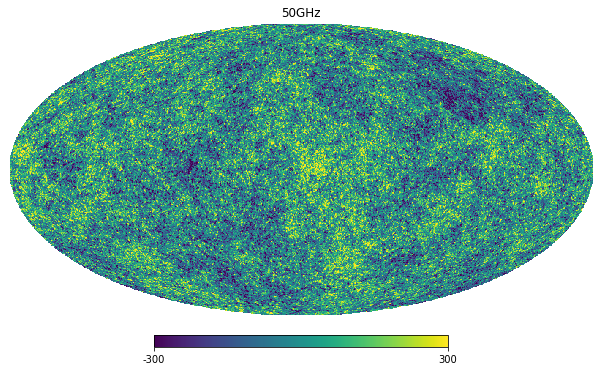

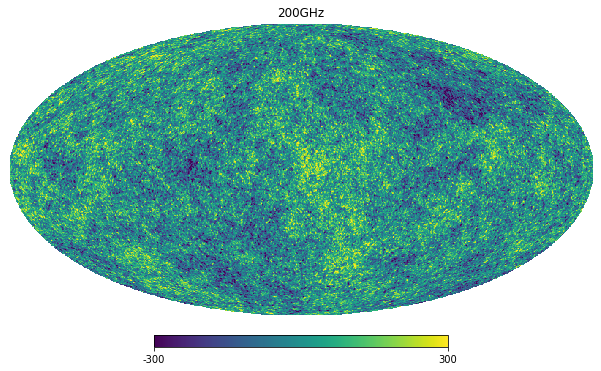

In [4]:
#### PLOTS OF MAPS ####
map_list = []
for i,fr in enumerate(freqs): 
    filename = '../data/test/maps/test_pl/{:d}GHz.fits'.format(int(fr))
#     filename = '../data/test/maps/test_sync/{:d}GHz.fits'.format(int(fr))
    map_list.append(hp.read_map(filename, verbose = False))
alms = uti.get_alms(map_list)
hp.mollview(map_list[0], min=-300,max=300, title = '50GHz')
plt.savefig('/Users/benjamin_brng/Desktop/50GHz_fg.png')
hp.mollview(map_list[-1], min=-300,max=300, title = '200GHz')
plt.savefig('/Users/benjamin_brng/Desktop/200GHz_fg.png')

(4, 4, 766)
(4, 4, 49)


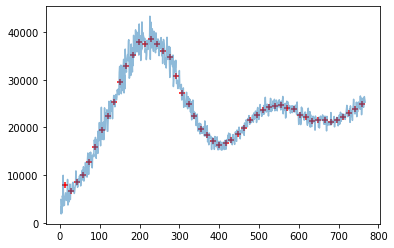

In [5]:
#### BINNING EMP COV + PLOT ####
bins = np.linspace(5,lmax,50).astype('int')
emp_cov = pre.empirical_covmat(alms)[...,2:]
ell = np.linspace(2,lmax,lmax-1)
ell_mean, emp_cov_binned = uti.bin_spectra(ell=ell, spectra=emp_cov, bins=bins) 
print(emp_cov.shape)
print(emp_cov_binned.shape)
plt.figure()
plt.plot(ell,ell**2*emp_cov[-2,-2,:], alpha = .5)
plt.scatter(ell_mean,ell_mean**2*emp_cov_binned[-2,-2,:], color = 'r', marker = '+')
# plt.yscale('log')
plt.show()

In [6]:
#### MODEL OF THE COVMAT ####

## Noise ##
noise = mod.WhiteNoise(ell=ell_mean, nu=freqs, nwhite=None)

## Foregrounds ##
# fgs_sed = mod.FreeSED(nu=freqs, sed=None)
fgs_sed = fgf.ThermalSZ(nu=freqs, nu_0 = 150.)
fgs_power = mod.FreeCls(ell=ell_mean, cls=None)
fgs = fgc.FactorizedCrossSpectrum(sed=fgs_sed, cl=fgs_power)

## CMB ##
cmb_cls = mod.FreeCls(ell=ell_mean, cls=None)
cmb_sed = mod.FreeSED(nu=freqs, sed=np.ones(N))
cmb = mod.FactorizedCrossSpectrum(sed=cmb_sed, cl=cmb_cls)

## Total ##
cl_mod = mod.Sum(cmb,fgs,noise)

In [7]:
#### STARTING POINT TOF THE OPTMIZATION ####

def start(emp_cov, dimension, bins):
    n_bins = len(bins) - 1
    bins_max = bins[1:]
    bins_min = bins[:-1]
    weights = np.array(
        [(bins_max[i] - bins_min[i]) * (bins_max[i] + bins_min[i]) for i in
         range(n_bins)])
    emp_tot = np.einsum('b,ijb->ij', weights/n_bins, emp_cov)
    _,eigvects = np.linalg.eigh(emp_tot)
    noise = np.diag(emp_tot)
    A = eigvects[::-1,::-1]
    p_l = np.einsum('ba,bcl,cd->adl',A,emp_cov,A)
    return noise, A[:,:dimension], p_l[:dimension,:dimension,:]

noise,A,pl = start(emp_cov_binned,2,bins)

## Start dictionary ##
dict_start = {'kwseq': [
    {'cl_kwargs': {'cls': pl[0,0,:]}},
    {'cl_kwargs': {'cls': pl[1,1,:]}},
    {'nwhite': np.sqrt(noise)}]}

mat_start = cl_mod.eval(**dict_start)

In [8]:
#### OPTIMIZATION ####

param_optimised = opti.optimiser_test(emp_cov=emp_cov_binned, model=cl_mod, param_start=dict_start, bins=bins, jac = None)

5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
5741238244759280.0
574123824475

231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896908.44
231251650896

1205344921891.5159
1205344921891.5156
1205344921891.5159
1205344921891.5159
1205344921891.5159
1205344921891.5159
1205344921891.516
1205344921891.5159
1205344921891.516
1205344921891.516
1205344921891.5164
1205344921891.5164
1205344921891.5164
1205344921891.5164
1205344921891.5168
1205344921891.5166
1205344921891.5168
1205344921891.5168
1205344921891.5168
1205344921891.5168
1205344921891.517
1205344921891.5173
1205344921891.5173
1205344921891.5173
1205344921891.5173
1205344921891.5176
1205344921891.5178
1205344921891.5178
1205344921891.518
1205344921891.518
1205344921891.5183
1205344921891.5183
1205344921891.5188
1205344921891.5186
1205344921891.519
1205344921891.519
1205344921891.5193
1205344921891.5195
1205344921891.5195
1205344921891.52
1205344921891.52
1205344921891.5203
1205344921891.5205
1205344921891.521
1205344921891.5212
1205344931534.6536
1205344910836.0784
1205344918088.0085
1205344920552.384
3066791150.141863
3066791150.14188
3066791150.1418743
3066791150.141864
3066791150.

1339292.2388490026
1339292.2388545412
1339292.238859793
1339292.2388692815
1339292.238875481
1339292.2388940009
1339292.2389062124
1339292.2389418308
1339292.2389820225
1339292.2390222612
1339292.2391057552
1339292.239185269
1339292.239331873
1339292.2394445504
1339292.2396367623
1339292.2396935117
1339292.23979559
1339292.2397843737
1339292.2398647731
1339292.2398780908
1339292.2398348232
1339292.2399694684
1339292.2399713963
1339292.2401693426
1339292.240198364
1339292.2405054853
1339292.2406504848
1339292.241089475
1339292.2414715912
1339292.2416784978
1339292.242272858
1339292.2424680563
1339292.2429945173
1339292.2429383332
1339292.2433660075
1339292.2431009545
1339292.2433774222
1339292.2434201352
1339292.2388300435
1339292.2388321103
1339292.2388429749
1339292.238855541
1339292.2388669807
1339292.2388949865
1339292.2389146045
1339292.2389500837
1339292.2389750856
1339292.2390114062
1339292.2390575663
1339292.2390882557
1339292.239149321
1339292.2391749525
1339292.2392479908
1339

1333902.0511798556
1333902.051253471
1333902.0512907824
1333902.0513546416
1333902.051369182
1333902.0515029829
1333902.0515272848
1333902.0515390737
1333902.0516162612
1333902.051609775
1333902.0517095744
1333902.0516877132
1333902.0518348916
1333902.0518144781
1333902.0519282324
1333902.0519149378
1333902.0520979273
1333902.0521652186
1333902.0521580915
1333902.0523194596
1333902.0523266075
1333902.0525105174
1333902.0524854374
1333902.0526728125
1333902.0526218023
1333902.052851168
1333902.0529650184
1333902.0529604245
1333902.0532006156
1333902.0531180962
1333902.0534575041
1333902.053438021
1333902.0537039638
1333902.05369129
1333902.0540130248
1333902.0541543718
1333902.051581294
1333902.050266199
1333902.054163995
1333902.0509170697
1333899.1043552742
1333899.104356301
1333899.1043559064
1333899.1043566086
1333899.1043579194
1333899.1043591143
1333899.104361381
1333899.1043631085
1333899.1043656417
1333899.1043677763
1333899.1043706383
1333899.1043741324
1333899.104376745
133389

1333166.8053528606
1333166.8053512848
1333166.8053518129
1333166.805353722
1333166.8053548886
1333166.8053570618
1333166.805358591
1333166.8053615529
1333166.8053637743
1333166.8053662283
1333166.8053706172
1333166.8053732708
1333166.805378755
1333166.8053838597
1333166.8053933764
1333166.8054001047
1333166.805417939
1333166.805430307
1333166.8054663376
1333166.8055061055
1333166.805546281
1333166.8056304054
1333166.8057093523
1333166.805855818
1333166.8059687251
1333166.806160862
1333166.806218013
1333166.8063204777
1333166.806308588
1333166.806388897
1333166.806402164
1333166.8063587882
1333166.8064938714
1333166.8064957354
1333166.806693724
1333166.8067220058
1333166.8070295332
1333166.807174273
1333166.8076140862
1333166.8079956826
1333166.808202295
1333166.8087967387
1333166.8089920166
1333166.809518864
1333166.8094622982
1333166.8098903582
1333166.8096252345
1333166.8099007858
1333166.809944268
1333166.8053521602
1333166.8053579004
1333166.805366993
1333166.8053800026
1333166.805

1300137.1171711292
1300137.1171997914
1300137.117505458
1300137.1176495838
1300137.1180858829
1300137.1184645141
1300137.118671416
1300137.1192607363
1300137.119454444
1300137.119971758
1300137.1199153534
1300137.1203386828
1300137.1200756023
1300137.1203466395
1300137.12038993
1300137.1158362941
1300137.1158365929
1300137.1158433768
1300137.115857669
1300137.1158752374
1300137.1159004637
1300137.1159208287
1300137.1159526363
1300137.1159789758
1300137.1160179994
1300137.116057231
1300137.1160909736
1300137.1161486434
1300137.1161763493
1300137.116248985
1300137.1162840843
1300137.1163500943
1300137.1163655
1300137.1164927634
1300137.1165169878
1300137.1165270316
1300137.1166016196
1300137.1165949258
1300137.116688784
1300137.1166692025
1300137.1168074585
1300137.1167866432
1300137.11689581
1300137.1168826988
1300137.117053041
1300137.1171141057
1300137.1171048067
1300137.1172522188
1300137.117256436
1300137.1174199444
1300137.1173952508
1300137.1175561545
1300137.117510713
1300137.117

1073756.2499526162
1073756.2499587596
1073756.249969017
1073756.2499753858
1073756.2499928675
1073756.2500052827
1073756.2500416087
1073756.2500811592
1073756.2501214421
1073756.2502050237
1073756.2502837474
1073756.250429497
1073756.2505414248
1073756.2507324668
1073756.2507890272
1073756.2508902294
1073756.2508786023
1073756.2509576418
1073756.2509706828
1073756.2509277635
1073756.2510612651
1073756.251062537
1073756.2512567344
1073756.2512841595
1073756.2515846293
1073756.2517254453
1073756.2521478713
1073756.2525128108
1073756.252704348
1073756.253263986
1073756.2534444048
1073756.2539080442
1073756.2538511893
1073756.2542275256
1073756.2539858036
1073756.254213524
1073756.2542486128
1073756.2499289901
1073756.2499332177
1073756.2499416624
1073756.2499547976
1073756.2499668403
1073756.249993659
1073756.2500134518
1073756.2500503836
1073756.250074065
1073756.250109301
1073756.2501555413
1073756.2501847928
1073756.250243735
1073756.250267492
1073756.2503374289
1073756.2503714291
1073

1059377.295066415
1059377.2947728208
1059377.292350476
1059377.2914160483
1059377.280333495
1059377.261196239
1059377.2330410823
1059377.1219148608
1059377.1933464124
1059377.3257073562
1059214.636962718
1059214.6369611556
1059214.63696328
1059214.636963805
1059214.6369652431
1059214.6369666671
1059214.6369688092
1059214.6369701321
1059214.6369729168
1059214.63697505
1059214.636978092
1059214.6369815145
1059214.636984127
1059214.6369900436
1059214.636995225
1059214.637005069
1059214.637011851
1059214.6370295389
1059214.6370418232
1059214.6370779288
1059214.637117621
1059214.6371578148
1059214.6372419223
1059214.6373205155
1059214.6374662912
1059214.6375784962
1059214.637769256
1059214.6378259067
1059214.6379271247
1059214.6379152336
1059214.6379945655
1059214.6380077708
1059214.6379645946
1059214.6380980592
1059214.6380995095
1059214.6382940174
1059214.6383215927
1059214.6386224465
1059214.6387635488
1059214.6391871336
1059214.6395531218
1059214.6397460168
1059214.6403083303
1059214.64

1058235.2157089456
1058235.2161325698
1058235.2164985551
1058235.216691465
1058235.2172539537
1058235.2174356652
1058235.2179049787
1058235.2178481573
1058235.2182295506
1058235.2179854957
1058235.2182177913
1058235.2182535878
1058235.2139106628
1058235.2139147676
1058235.2139235148
1058235.2139365587
1058235.2139488887
1058235.2139757
1058235.213995484
1058235.214031656
1058235.2140557454
1058235.21409147
1058235.2141374024
1058235.2141666592
1058235.2142261018
1058235.2142499299
1058235.21432024
1058235.214353862
1058235.2144122038
1058235.2144238828
1058235.2145393176
1058235.2145544384
1058235.214561405
1058235.2146210035
1058235.2146089377
1058235.2146834147
1058235.2146631286
1058235.2147573424
1058235.2147422447
1058235.214809885
1058235.2147994826
1058235.214889815
1058235.2149151894
1058235.2148977634
1058235.2149516258
1058235.2149286673
1058235.2149327598
1058235.2149017954
1058235.2148499952
1058235.214846292
1058235.2146414996
1058235.2144660393
1058235.2143166864
1058235.

1031964.1159345476
1031964.1159916092
1031964.11597874
1031964.1160494976
1031964.1160297643
1031964.1161165527
1031964.1161026898
1031964.1161637469
1031964.1161536755
1031964.116230857
1031964.1162496109
1031964.1162310638
1031964.1162675868
1031964.1162390783
1031964.1162115141
1031964.1161793403
1031964.1160824827
1031964.1160873845
1031964.1157933691
1031964.1155505017
1031964.1153649719
1031964.1147083889
1031964.1148889863
1031964.1127308075
1031964.1123624404
1031964.1093791522
1031964.1083637519
1031964.1027757662
1031964.1073446773
1031963.9153755343
1031965.1468802064
1031964.7038993543
1031963.8867817044
1020255.5745062873
1020255.5744983519
1020255.5745085598
1020255.5745053823
1020255.5745100275
1020255.57450943
1020255.5745090937
1020255.574511639
1020255.5745149375
1020255.5745175799
1020255.5745210481
1020255.5745253937
1020255.5745300938
1020255.5745297222
1020255.5745398457
1020255.5745480681
1020255.574555758
1020255.5745742287
1020255.5745850623
1020255.5746218169


990484.0744081273
990484.0744645831
990484.0745650114
990484.0745534734
990484.0746322237
990484.0746453058
990484.0746023895
990484.0747349625
990484.0747365558
990484.074929588
990484.0749565817
990484.0752544942
990484.0753939542
990484.0758099961
990484.07616769
990484.0763527758
990484.0768961515
990484.0770685994
990484.0774980828
990484.0774403883
990484.0777856612
990484.0775584739
990484.0777572165
990484.0777874992
990484.0736055714
990484.073611953
990484.0736189457
990484.0736322234
990484.0736439443
990484.073670121
990484.0736913006
990484.0737265729
990484.0737509148
990484.073784659
990484.0738319
990484.0738616225
990484.0739194031
990484.0739431821
990484.0740111412
990484.0740434101
990484.074099303
990484.0741099408
990484.0742173443
990484.0742275803
990484.0742319347
990484.0742830745
990484.074268673
990484.0743302503
990484.0743108676
990484.0743767999
990484.0743645538
990484.0744063323
990484.0743974459
990484.0744308324
990484.0744292592
990484.0744036827
990

960153.0109874043
960153.0109599491
960153.0109204494
960153.0108664001
960153.0106898197
960153.0106493155
960153.010320783
960153.0103721004
960153.0095725171
960153.0089107798
960153.0084719164
960153.0064525118
960153.0070560875
960152.999858218
960152.9985607582
960152.9910425306
960152.9911299478
960153.0061723611
960153.0125398581
960152.9636479152
960152.9973415897
960152.5822863677
960152.9816389697
952953.4436547615
952953.4436557221
952953.4436560503
952953.4436565116
952953.4436571806
952953.4436583689
952953.4436610127
952953.4436624503
952953.443665459
952953.4436668219
952953.4436702206
952953.4436738085
952953.4436760984
952953.4436824339
952953.4436868874
952953.4436972863
952953.4437042124
952953.4437213045
952953.4437338974
952953.4437702984
952953.4438096747
952953.4438497415
952953.4439337346
952953.444012034
952953.4441576762
952953.4442697484
952953.4444595576
952953.4445159548
952953.4446164498
952953.4446047795
952953.4446834446
952953.4446963834
952953.4446534

1130682.6932489371
1130682.6932687175
1130682.693292152
1130682.6933298733
1130682.6933519484
1130682.693398053
1130682.6934436758
1130682.6934721677
1130682.6935232815
1130682.6935461767
1130682.6936110614
1130682.6936436899
1130682.6936954611
1130682.6937097607
1130682.6938058578
1130682.6938136104
1130682.693819008
1130682.6938562756
1130682.6938418197
1130682.69388707
1130682.6938695754
1130682.6938994594
1130682.6938941537
1130682.6939042995
1130682.6938981523
1130682.6938613886
1130682.6938234929
1130682.6937845196
1130682.6936626171
1130682.6935799152
1130682.6932280015
1130682.6931776379
1130682.6925543465
1130682.6926657779
1130682.6911634712
1130682.6898484326
1130682.6889933937
1130682.6845844989
1130682.6859493388
1130682.6734559701
1130682.672904072
1130682.6797488092
1130682.6839198342
1130682.6952677162
1130682.6977869417
1130681.516442053
1130691.6028396182
1130683.837953952
1130683.1189199078
937615.0657887792
937615.0657890929
937615.0657897359
937615.0657900812
93761

925951.0917100168
925951.0917229383
925951.0917584684
925951.0917978974
925951.091837876
925951.0919217056
925951.0920004505
925951.0921460177
925951.0922577633
925951.092447061
925951.0925032203
925951.0926033998
925951.092591727
925951.0926702404
925951.0926834886
925951.0926403238
925951.0927721753
925951.0927733909
925951.0929652313
925951.0929916588
925951.0932861266
925951.0934237465
925951.0938308107
925951.09417939
925951.0943547001
925951.0948733757
925951.0950324702
925951.0954036033
925951.095344035
925951.0956308593
925951.0954320569
925951.0955761089
925951.0955973146
925951.0916486443
925951.0916512918
925951.0916572508
925951.0916721224
925951.0916835144
925951.0917113362
925951.0917310459
925951.0917656283
925951.0917908729
925951.0918253773
925951.0918709164
925951.0918996175
925951.0919569565
925951.0919798837
925951.0920474089
925951.0920781039
925951.0921318447
925951.0921410492
925951.0922391765
925951.0922456996
925951.0922472398
925951.0922888113
925951.092271171

910678.6706713007
910678.6702605549
910678.6702067466
910678.6694879011
910678.6696179186
910678.6679059241
910678.6664232054
910678.6654987955
910678.6609536947
910678.6623068904
910678.6552090256
910678.6561094013
910678.6639651321
910678.666598784
910678.6736419187
910678.675398673
910678.6753139751
910678.4469462393
910678.6744685649
910678.6214270494
908376.29275828
908376.2927579603
908376.29275852
908376.2927594256
908376.2927608669
908376.2927622816
908376.2927645615
908376.2927655922
908376.292768727
908376.2927705923
908376.2927738018
908376.2927769697
908376.2927796033
908376.2927857394
908376.2927910036
908376.2928004954
908376.2928073348
908376.2928251529
908376.2928371943
908376.292873373
908376.2929131857
908376.292953105
908376.2930371924
908376.2931154505
908376.293260741
908376.2933724273
908376.2935615384
908376.2936177859
908376.2937176416
908376.2937061178
908376.2937843566
908376.2937972473
908376.2937543382
908376.2938860658
908376.2938871545
908376.2940782555
90

905897.3597518526
905897.359771549
905897.3598076971
905897.3598318544
905897.359866423
905897.3599113505
905897.3599392736
905897.3599978539
905897.3600197986
905897.3600858407
905897.3601152448
905897.3601669797
905897.3601748651
905897.3602664254
905897.3602694317
905897.3602692944
905897.3603035756
905897.3602840096
905897.360319777
905897.3603021018
905897.3603087608
905897.3603029216
905897.3602893335
905897.3602829389
905897.3601857447
905897.3601180094
905897.3600720124
905897.359856874
905897.3597388602
905897.3591809059
905897.3591173734
905897.3581320969
905897.3583169635
905897.3559271009
905897.3537863701
905897.3524847319
905897.346289862
905897.3480529425
905897.3452918236
905897.3473181422
905897.3563424762
905897.3584134489
905897.3636458832
905897.3649703782
905897.4393171397
905897.4894036222
905897.7114401935
905897.4208826602
904793.983163458
904793.9831624646
904793.9831639993
904793.9831647201
904793.9831660438
904793.983167396
904793.9831693397
904793.983170444


896524.4616164109
896524.4616557925
896524.4616960069
896524.4617799986
896524.4618584899
896524.4620035294
896524.4621150682
896524.4623037032
896524.4623597483
896524.4624595684
896524.4624480472
896524.4625259419
896524.4625389071
896524.4624959673
896524.4626272791
896524.462628368
896524.4628185575
896524.4628447101
896524.4631359794
896524.463271565
896524.4636697611
896524.4640074598
896524.4641714393
896524.4646600782
896524.4648013904
896524.4650903281
896524.465026723
896524.465220671
896524.4650688941
896524.4651244569
896524.4651307883
896524.4615000659
896524.4615087105
896524.4615167446
896524.4615296249
896524.4615421676
896524.461568695
896524.4615882139
896524.4616244771
896524.4616486186
896524.4616836482
896524.4617282196
896524.4617562179
896524.4618146846
896524.4618360829
896524.4619018039
896524.4619308645
896524.4619818844
896524.4619895475
896524.4620791613
896524.4620809046
896524.4620798999
896524.4621118903
896524.4620917923
896524.4621237675
896524.46210627

910423.7170394802
910423.71677461
910423.7166465939
910423.7160655562
910423.7160130953
910423.7152358502
910423.7153668491
910423.7145338797
910423.7147613964
910423.7152103138
910423.7170110492
910423.716565727
910423.717661143
910423.7172683127
910423.7142007413
910423.7142843638
910423.7200853734
910423.721912341
910428.2829398896
910421.2006691907
910423.0397686124
910423.604175915
848720.3288150012
848720.328816734
848720.3288179234
848720.3288153
848720.328817524
848720.3288193542
848720.3288217639
848720.3288217048
848720.328824488
848720.3288261127
848720.3288300863
848720.3288351514
848720.3288369225
848720.3288436695
848720.3288475149
848720.3288567599
848720.3288648578
848720.3288808297
848720.3288952962
848720.3289306617
848720.3289694905
848720.3290100994
848720.3290935599
848720.3291717555
848720.3293172277
848720.3294284961
848720.3296172225
848720.329673181
848720.3297736074
848720.3297612999
848720.3298388633
848720.32985195
848720.329809048
848720.3299403121
848720.3

917675.4101659083
917675.4101912798
917675.4104810501
917675.4106156105
917675.4110080319
917675.4113393549
917675.411496486
917675.4119649029
917675.4120940361
917675.4123234751
917675.4122570655
917675.4123785563
917675.4122649655
917675.4122514571
917675.4122465961
917675.4088483031
917675.40885867
917675.4088682899
917675.4088804491
917675.4088917886
917675.4089196506
917675.4089393343
917675.4089750354
917675.4089978999
917675.4090296249
917675.4090754846
917675.4091066092
917675.409161075
917675.4091838426
917675.4092505177
917675.4092785097
917675.4093278887
917675.4093338323
917675.4094187625
917675.4094178143
917675.4094159657
917675.4094414786
917675.4094202798
917675.4094434624
917675.4094272666
917675.4094063388
917675.4094023996
917675.4093635143
917675.4093580623
917675.4092036749
917675.409108879
917675.4090557827
917675.4087751987
917675.4086425037
917675.4080567092
917675.4080073928
917675.4073263773
917675.4074318396
917675.4070897169
917675.4077233524
917675.40829806

745497.3040919313
745497.3059800135
745497.3054485888
745497.2919507524
745497.2870935946
745497.3074237554
745497.309501158
745497.3911727689
745496.3477740772
745497.3056344189
745497.1691124695
729657.8335103743
729657.8335099829
729657.8335109503
729657.8335114113
729657.83351302
729657.8335142914
729657.8335161733
729657.8335187334
729657.8335209562
729657.833523224
729657.8335258194
729657.8335293456
729657.8335318955
729657.8335373561
729657.8335430707
729657.8335527234
729657.833559705
729657.8335780542
729657.8335889709
729657.8336256664
729657.8336652541
729657.8337051499
729657.8337891683
729657.8338669449
729657.8340115774
729657.8341222346
729657.834309827
729657.8343654032
729657.834463913
729657.8344525396
729657.834529586
729657.8345420811
729657.8344998492
729657.8346291689
729657.8346296882
729657.8348161961
729657.8348412121
729657.8351239021
729657.8352541074
729657.8356263832
729657.8359307385
729657.8360557369
729657.836426355
729657.8364822422
729657.8362888886
7

703030.1034110031
703030.1034548245
703030.1034587452
703030.1035201857
703030.1035077369
703030.1034979227
703030.1034981727
703030.1034678663
703030.1034470515
703030.1034336975
703030.1032986902
703030.1033079191
703030.103152016
703030.1031513372
703030.1026691202
703030.1023874492
703030.102268221
703030.1013608277
703030.1009642885
703030.0988813572
703030.0987639717
703030.0965790031
703030.096888501
703030.0982525372
703030.1010000972
703030.1023772182
703030.1050256947
703030.1045425178
703030.1057198287
703030.1053578977
703030.094964628
703030.0783116153
703030.1039419905
703030.1079703748
703030.4936850304
703029.9395851963
703030.5421984395
703030.1526486927
698485.263101982
698485.2631048353
698485.2631021151
698485.2631033154
698485.263104517
698485.2631060088
698485.263107782
698485.2631091741
698485.263111897
698485.2631143028
698485.2631169774
698485.2631207397
698485.263124346
698485.2631287281
698485.2631349675
698485.2631443312
698485.2631509928
698485.2631687615
6

689096.7552205183
689096.7551780132
689096.7553070121
689096.7553075274
689096.7554926513
689096.7555171436
689096.755796624
689096.75592471
689096.7562863898
689096.756576094
689096.7566822708
689096.7569883441
689096.7569880581
689096.7563840825
689096.756234104
689096.7543221711
689096.7554714916
689096.7529958811
689096.7524646472
689096.7541887532
689096.7541986712
689096.7542059174
689096.7542194586
689096.7542316933
689096.7542584195
689096.7542777184
689096.7543134281
689096.7543372301
689096.7543718255
689096.7544160689
689096.7544433038
689096.7544983843
689096.7545181412
689096.7545796112
689096.7546025804
689096.7546454885
689096.7546483434
689096.7547049824
689096.7546895054
689096.7546783765
689096.7546722124
689096.7546397549
689096.75460839
689096.7545956554
689096.7544333102
689096.7544453162
689096.7542613082
689096.7542619222
689096.7537019352
689096.7533779165
689096.7532455832
689096.7522188632
689096.7517892594
689096.7497207051
689096.7496546459
689096.748501044


687908.9733358966
687908.9734197002
687908.9734975978
687908.9736422164
687908.9737529004
687908.9739395522
687908.9739949601
687908.9740931244
687908.9740816981
687908.9741583191
687908.9741708522
687908.974128371
687908.9742573055
687908.9742578492
687908.9744429279
687908.9744674024
687908.9747467607
687908.9748747754
687908.9752362164
687908.9755253231
687908.9756308659
687908.9759350048
687908.9759328817
687908.9753172041
687908.9751660858
687908.9732258428
687908.974392871
687908.9718957994
687908.9713645945
687908.9731455068
687908.9731482428
687908.9731565558
687908.9731699269
687908.9731821432
687908.9732085775
687908.9732283353
687908.9732637941
687908.9732876781
687908.973321864
687908.9733653779
687908.9733943108
687908.9734490453
687908.9734685646
687908.9735297423
687908.9735528827
687908.9735956953
687908.9735985018
687908.9736548963
687908.9736394429
687908.9736281439
687908.9736218347
687908.9735894387
687908.9735584417
687908.9735456281
687908.9733840919
687908.973396

709922.5109995629
709922.5096880698
709922.5096667091
709922.5086934341
709922.5088727395
709922.5089823782
709922.5111248167
709922.5124843621
709922.5152257303
709922.5147278561
709922.5159330772
709922.515566655
709922.5084241354
709922.5116316153
709922.5143613768
709922.5181258781
709921.2201997848
709918.6843539583
709922.1277859731
709923.0563429139
675816.256292658
675816.2562940778
675816.2562938702
675816.2562934567
675816.256294994
675816.2562967592
675816.25629947
675816.2563000203
675816.2563028437
675816.2563057215
675816.2563076644
675816.2563117115
675816.2563137553
675816.2563206383
675816.25632513
675816.2563347995
675816.2563422503
675816.256359388
675816.2563716519
675816.256407671
675816.2564472697
675816.2564873578
675816.2565712634
675816.2566490357
675816.2567936372
675816.2569043079
675816.2570909123
675816.2571463262
675816.2572444795
675816.257233111
675816.257309685
675816.2573221467
675816.2572797689
675816.2574087349
675816.2574091031
675816.2575943877
675

663207.5731287953
663207.5731490154
663207.5731849434
663207.5732079952
663207.5732428537
663207.573286823
663207.5733141808
663207.5733690425
663207.5733879262
663207.5734497572
663207.5734719918
663207.573513835
663207.573516541
663207.5735696823
663207.5735526246
663207.5735392593
663207.5735293068
663207.5734953023
663207.5734570128
663207.5734449155
663207.5732646917
663207.5732784565
663207.5730776398
663207.5730789715
663207.5724840276
663207.5721503034
663207.57201922
663207.5710397391
663207.5706765746
663207.5691849138
663207.569163769
663207.5681717029
663207.5683427278
663207.5689913338
663207.5713505349
663207.5726944761
663207.5753148231
663207.5748413017
663207.576001003
663207.5756509956
663207.567427144
663207.5703293621
663207.573065026
663207.5779696392
663207.429190763
663207.2316432007
663207.7825237239
663207.662846664
658127.4866389183
658127.4866366673
658127.4866387049
658127.4866383353
658127.4866419637
658127.4866428464
658127.4866436338
658127.4866471535
658

617632.8319926306
617632.8320669582
617632.8342342959
617632.8342404794
617632.8342496213
617632.8342620025
617632.8342741735
617632.8343009172
617632.8343206642
617632.8343552285
617632.8343791304
617632.8344132564
617632.8344576604
617632.8344854842
617632.8345411342
617632.8345592021
617632.8346176047
617632.8346397339
617632.8346803259
617632.8346802061
617632.8347274519
617632.8347055735
617632.83469124
617632.8346726943
617632.8346367049
617632.8345863512
617632.8345762445
617632.8343748688
617632.8343908475
617632.8341794348
617632.834181217
617632.8336332665
617632.833379192
617632.8332968985
617632.8328367812
617632.8327912408
617632.8329503675
617632.8330066155
617632.8330936432
617632.8331521563
617632.8311420328
617632.8308815826
617632.8320907868
617632.8357456364
617632.8350754452
617632.8364174761
617632.8357525659
617632.8270617672
617632.8367916031
617632.8265447876
617632.8384617289
617633.5063318821
617633.4030122723
617632.2758963028
617632.7967048662
610289.9235941

599689.0222054777
599689.0222102206
599689.0222156132
599689.0222254399
599689.0222321138
599689.0222500159
599689.0222622055
599689.0222980528
599689.02233774
599689.022377724
599689.0224613951
599689.0225391936
599689.0226834399
599689.0227938119
599689.0229797413
599689.0230347392
599689.0231322508
599689.0231208616
599689.0231968501
599689.0232093345
599689.0231671247
599689.0232948437
599689.0232952803
599689.023477937
599689.0235017635
599689.0237757645
599689.0239001954
599689.0242430205
599689.0245051113
599689.0245742236
599689.024744982
599689.0246147482
599689.0231137858
599689.0228796261
599689.0210763591
599689.0217000487
599689.0216610061
599689.0219890912
599689.0221876168
599689.0221912409
599689.0221984874
599689.0222113262
599689.0222235998
599689.0222504364
599689.0222703031
599689.0223052915
599689.0223291166
599689.0223632624
599689.0224069104
599689.0224348507
599689.0224886512
599689.0225070352
599689.0225668502
599689.0225875381
599689.0226267875
599689.02262783

598335.8473628873
598335.8473475014
598335.8473267611
598335.8472906393
598335.8472385117
598335.8472280327
598335.8470346453
598335.8470492836
598335.8468629413
598335.8468645874
598335.8464751212
598335.8463534038
598335.8463308236
598335.8463475878
598335.8464772108
598335.8471472648
598335.8471945489
598335.8475273808
598335.847523527
598335.845600391
598335.8428239515
598335.8426115786
598335.8471724957
598335.8461411588
598335.8476989245
598335.8461801347
598335.8439233042
598335.850735376
598335.8325244532
598335.8498224539
598335.8723880233
598335.8195086964
598335.8695958175
598335.8659625221
599679.6890846308
599679.6890881165
599679.6890836515
599679.6890872625
599679.6890876737
599679.6890882499
599679.6890904563
599679.6890917737
599679.6890951699
599679.6890975368
599679.6891009217
599679.6891027348
599679.6891063167
599679.6891119662
599679.6891176712
599679.6891272148
599679.6891342028
599679.6891515541
599679.689163214
599679.6891998063
599679.6892393593
599679.6892794

594347.9153058947
594347.9154189188
594347.915224956
594347.9131555635
594347.9128524219
594347.9109373892
594347.9113424666
594347.9122076983
594347.9127130255
594347.912952381
594347.9129574868
594347.9129662828
594347.9129793412
594347.9129911439
594347.9130172145
594347.9130376388
594347.9130730614
594347.9130962848
594347.9131303532
594347.9131747877
594347.9132009236
594347.913255222
594347.9132735372
594347.9133332338
594347.9133529327
594347.91339123
594347.9133910929
594347.9134300639
594347.9134054522
594347.913388719
594347.91336456
594347.9133270122
594347.9132685903
594347.9132588175
594347.9130526601
594347.9130684026
594347.9128734613
594347.9128754501
594347.9124892968
594347.9123836339
594347.9123713843
594347.9124608968
594347.912620251
594347.9133651123
594347.9134126086
594347.9137856358
594347.9137717896
594347.9120317583
594347.9093916122
594347.909079833
594347.9133543024
594347.9123482755
594347.9138912741
594347.9124268837
594347.9112318394
594347.9169375071
59

590972.659625188
590972.659630312
590972.6596354357
590972.6596452532
590972.6596516897
590972.6596696154
590972.6596818819
590972.6597178006
590972.6597575452
590972.6597973312
590972.6598810641
590972.65995888
590972.6601030275
590972.6602131882
590972.6603987939
590972.6604538156
590972.6605509893
590972.6605396433
590972.6606155566
590972.6606278379
590972.6605855437
590972.6607130846
590972.6607133136
590972.6608952511
590972.6609186037
590972.6611903667
590972.6613131282
590972.6616478179
590972.6618969933
590972.6619474011
590972.6620400734
590972.6618198858
590972.6593751685
590972.6589991321
590972.6559500871
590972.656914285
590972.6576300883
590972.6582778963
590972.65960652
590972.6596102993
590972.6596184421
590972.6596314216
590972.6596437743
590972.6596700508
590972.65968995
590972.6597252664
590972.6597487776
590972.6597825991
590972.6598265095
590972.6598540222
590972.659907654
590972.6599259502
590972.6599844905
590972.6600040646
590972.660042055
590972.660042374
5909

590066.2644723352
590066.2644737057
590066.264475108
590066.2644774207
590066.2644783086
590066.2644815923
590066.2644833492
590066.2644865984
590066.2644901742
590066.2644928985
590066.2644985513
590066.2645038046
590066.2645135823
590066.2645203272
590066.2645379646
590066.2645503058
590066.2645861739
590066.2646258024
590066.2646657164
590066.2647495737
590066.2648272555
590066.2649713379
590066.2650815237
590066.2652670203
590066.2653219557
590066.2654190833
590066.2654077316
590066.2654834976
590066.2654959
590066.2654536249
590066.2655810377
590066.2655812784
590066.2657629686
590066.2657863111
590066.2660574828
590066.2661799785
590066.2665126178
590066.2667587962
590066.2668045867
590066.2668779088
590066.2666343767
590066.2639383384
590066.2635251818
590066.2604633092
590066.2612664594
590066.262495872
590066.2632134436
590066.264474517
590066.2644773851
590066.2644871051
590066.2644997564
590066.2645122084
590066.2645385655
590066.2645581703
590066.2645934717
590066.26461685


{'kwseq': [{'cl_kwargs': {'cls': array([2.24156116e+02, 3.71699672e+01, 1.86185354e+01, 1.20555178e+01,
       9.40633112e+00, 8.15974220e+00, 7.14840070e+00, 6.26364521e+00,
       5.53083653e+00, 5.22276150e+00, 4.75525391e+00, 4.25604272e+00,
       3.90024704e+00, 3.30076327e+00, 2.96759269e+00, 2.53451895e+00,
       2.16290947e+00, 1.86047695e+00, 1.48236249e+00, 1.18251160e+00,
       9.84799388e-01, 8.09225841e-01, 6.50894756e-01, 5.55459403e-01,
       4.72250009e-01, 4.06164373e-01, 3.82630939e-01, 3.66287390e-01,
       3.63095659e-01, 3.58773971e-01, 3.59770261e-01, 3.54781852e-01,
       3.43577112e-01, 3.28835297e-01, 3.01197719e-01, 2.82498098e-01,
       2.44720467e-01, 2.18541763e-01, 1.68463004e-01, 1.32839274e-01,
       1.02329177e-01, 6.81007207e-02, 4.99554075e-02, 1.93612900e-02,
       1.73410402e-02, 1.21292803e-02, 1.26098465e-02, 1.69921148e-02,
       1.93712335e-02])}}, {'cl_kwargs': {'cls': array([4.85547064, 1.25496702, 0.76859678, 0.54103842, 0.44605915,

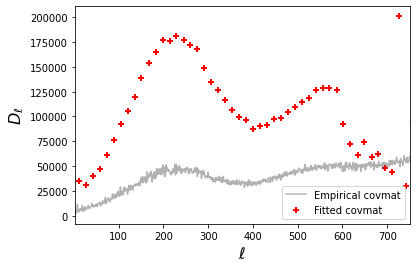

In [9]:
#### PLOT OF BEST-FIT ####

print(param_optimised)
lst = cl_mod.eval_terms(**param_optimised)
cov_opti = cl_mod.eval(**param_optimised)
i=0
plt.figure()
plt.plot(ell,ell**2*emp_cov[i,i,:],alpha = .3, c = 'k', label = 'Empirical covmat')
# plt.scatter(ell_mean,ell_mean**2*mat_start[i,i,:],lw=2, c = 'g', label = 'Start covmat', marker = '+')
plt.scatter(ell_mean,ell_mean**2*cov_opti[i,i,:],lw=2, c = 'r', label = 'Fitted covmat', marker = '+')
plt.xlabel('$\ell$', fontsize=16)
plt.xlim(2,750)
plt.ylabel('$D_\ell$', fontsize =16)
# plt.yscale('log')
plt.legend()
plt.savefig('/Users/benjamin_brng/Desktop/cl_100GHz_fgs.png')
plt.show()

In [10]:
#### WIENER FILTERTING ####
cpt = 0
inv_R = (np.linalg.inv(cov_opti.T)).T
w = np.einsum('abl,bcl->acl',lst[cpt],inv_R)
w_full = np.zeros((N,N,lmax+1))
bins_max = bins[1:]
bins_min = bins[:-1]
for i in range(len(bins)-1):
    w_full[...,bins_min[i]:bins_max[i]] = np.tile(w[...,i,np.newaxis],bins_max[i]-bins_min[i])
alm_filter  = alms.copy()
print(alms.shape)
for l in range(0,lmax-1) : 
    ind_list = []
    for m in range(0,l+1):
        ind_list.append(hp.Alm.getidx(lmax,l,m)) 
    alm_filter[:,ind_list] = np.dot(w_full[:,:,l],alms[:,ind_list])

(4, 295296)


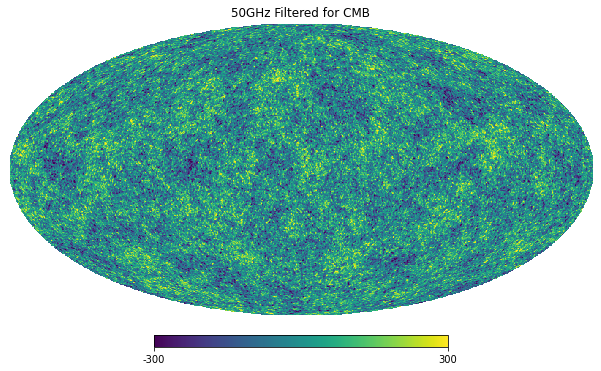

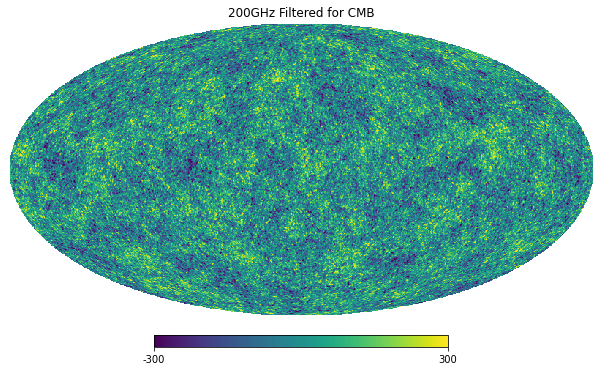

In [11]:
#### WIENER FILETERED MAPS ####3 

maps_resulting = []
for alm in alm_filter:
    maps_resulting.append(hp.alm2map(alm, nside=nside, verbose = False))
    
hp.mollview(maps_resulting[0], min=-300,max=300, title = '50GHz Filtered for CMB')
plt.savefig('/Users/benjamin_brng/Desktop/50GHz_CMB_fgs.png')
hp.mollview(maps_resulting[-1], min=-300,max=300, title = '200GHz Filtered for CMB')
plt.savefig('/Users/benjamin_brng/Desktop/200GHz_CMB_fgs.png')

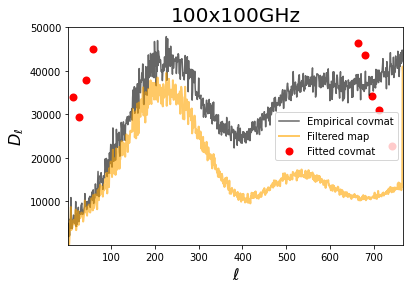

In [12]:
plt.figure()
cl_test = hp.anafast(maps_resulting[1])
ell_test = np.linspace(0,lmax,lmax+1)
plt.plot(ell,ell**2*emp_cov[1,1,:],alpha = .6, c = 'k', label = 'Empirical covmat')
plt.scatter(ell_mean,ell_mean**2*cov_opti[1,1,:],lw=2, c = 'r', label = 'Fitted covmat')
plt.plot(ell_test,ell_test**2*cl_test,alpha = .6,lw=2, c = 'orange', label = 'Filtered map')
plt.xlabel('$\ell$', fontsize=16)
plt.xlim(2,lmax)
plt.ylim(1e-5,50000)
plt.ylabel('$D_\ell$', fontsize =16)
plt.title('100x100GHz', fontsize = 20)
# plt.yscale('log')
plt.legend()
plt.savefig('/Users/benjamin_brng/Desktop/cl_100GHz_filtered_fgs.png')
#
plt.show()